# Tutorial 08

## template fitting mock data test (simple likelihood, B mode, non-parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.methods.tpfit import tpfit_simple
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cmbmodel
from afra.tools.aux import vec_simple
from afra.tools.ps_estimator import pstimator
import seaborn as sns
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -3.3}
cmb truths:  {'bp_c_B_121.5': 0.006980967502059658, 'bp_c_B_201.5': 0.014132489878044883}


iter: 11379 | +1000 | bound: 18 | nc: 1 | ncall: 62959 | eff(%): 19.662 | loglstar:   -inf < -0.001 <    inf | logz: -11.161 +/-  0.144 | dlogz:  0.001 >  1.009                                      

CPU times: user 35min 8s, sys: 16.8 s, total: 35min 24s
Wall time: 12min 3s


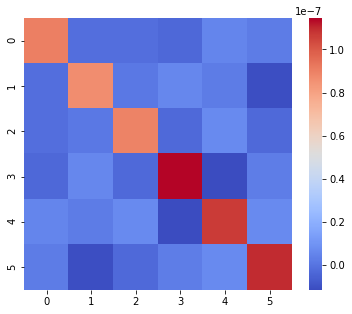

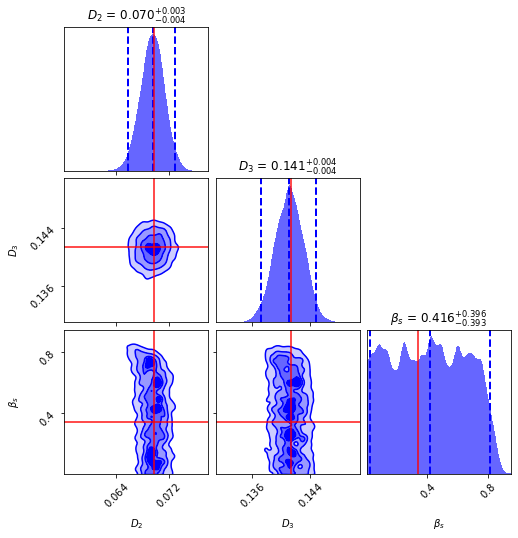

In [2]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s':-3.3})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_eb = est.auto_eb(mapcmb[1:])
for i in range(len(auto_cmb_eb[0])):
    name = 'bp_c_B_'+str(auto_cmb_eb[0][i])
    b.reset({name: auto_cmb_eb[2][i]})
    
print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(s.bandpower()+b.bandpower())

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = s
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp,mock_cov,kwargs=KWARGS)

truths = list(auto_cmb_eb[2][1:]/0.1) + [(5.-3.3)/5.]
labels = [r'$D_2$',r'$D_3$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 1.5}
cmb truths:  {'bp_c_B_121.5': 0.006980967502059658, 'bp_c_B_201.5': 0.014132489878044883}


iter: 18339 | +1000 | bound: 22 | nc: 1 | ncall: 68565 | eff(%): 28.205 | loglstar:   -inf < -0.003 <    inf | logz: -18.232 +/-  0.194 | dlogz:  0.001 >  1.009                                      

CPU times: user 37min 14s, sys: 16.2 s, total: 37min 30s
Wall time: 12min 42s


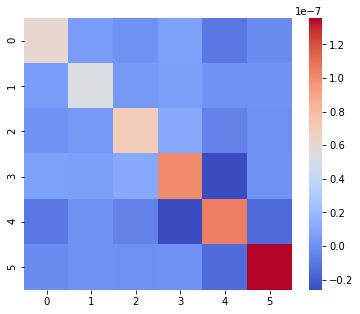

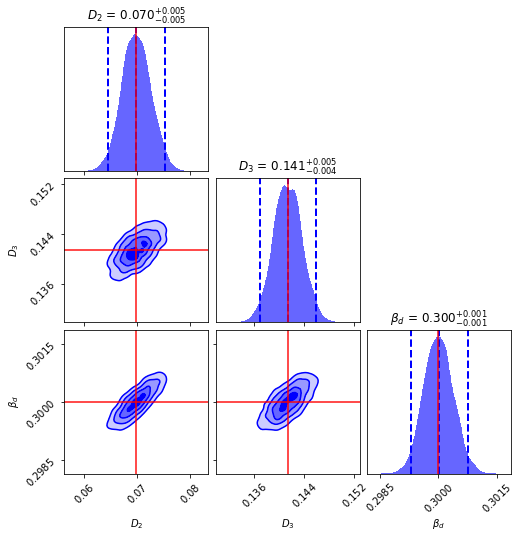

In [3]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f[1:]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_eb = est.auto_eb(mapcmb[1:])
for i in range(len(auto_cmb_eb[0])):
    name = 'bp_c_B_'+str(auto_cmb_eb[0][i])
    b.reset({name: auto_cmb_eb[2][i]})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(d.bandpower()+b.bandpower())

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = d
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp,mock_cov,kwargs=KWARGS)

truths = list(auto_cmb_eb[2][1:]/0.1) + [1.5/5.]
labels = [r'$D_2$',r'$D_3$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.3, 'beta_d': 1.5, 'rho': 0.1}
cmb truths:  {'bp_c_B_121.5': 0.006980967502059658, 'bp_c_B_201.5': 0.014132489878044883}


iter: 18132 | +1000 | bound: 38 | nc: 1 | ncall: 92014 | eff(%): 20.792 | loglstar:   -inf < -0.002 <    inf | logz: -18.071 +/-  0.196 | dlogz:  0.001 >  1.009                                      

CPU times: user 49min 4s, sys: 23.1 s, total: 49min 27s
Wall time: 16min 55s


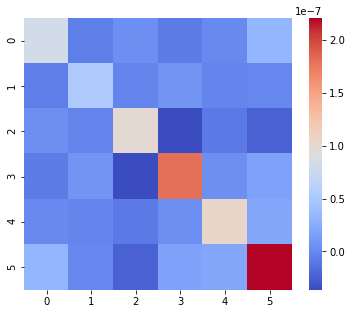

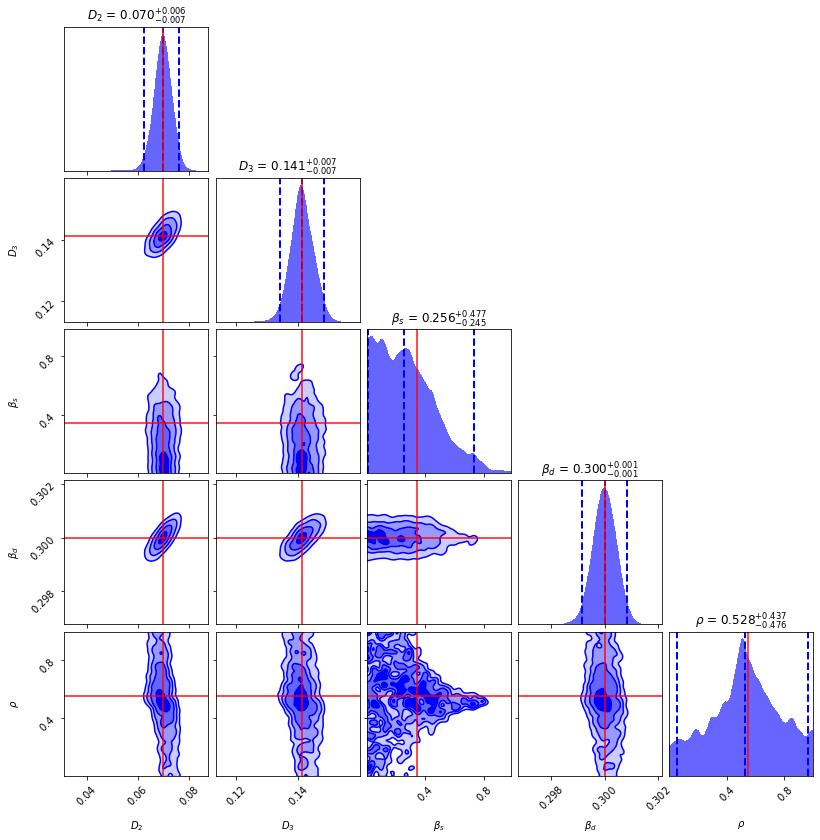

In [4]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 40
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.3})
c.reset({'beta_d':1.5})
c.reset({'rho':0.1})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_eb = est.auto_eb(mapcmb[1:])
for i in range(len(auto_cmb_eb[0])):
    name = 'bp_c_B_'+str(auto_cmb_eb[0][i])
    b.reset({name: auto_cmb_eb[2][i]})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(c.bandpower()+b.bandpower())

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = c
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp,mock_cov,kwargs=KWARGS)

truths = list(auto_cmb_eb[2][1:]/0.1) + [(5.-3.3)/5.,1.5/5.,1.1/2.]
labels = [r'$D_2$',r'$D_3$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

end